<a href="https://colab.research.google.com/github/Lidiia-Afanasieva/ISSvsSteven/blob/main/ISSvsSteven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Общее**
Афанасьева Л.В, Зиновьев Д.К

Стивен из вселенной Стивена и международная космическая станция

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [76]:
# Kinda important
import tensorflow as tf
from PIL import Image
import os
from urllib.request import urlopen
import io
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from multipledispatch import dispatch
import itertools
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Helper libraries
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sn
from copy import deepcopy

from urllib.error import HTTPError
import sys

# for classification_report overriding
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate


In [ ]:
!pip install multipledispatch
# !pip install sklearn.utils.multiclass.unique_labels
# !pip install sklearn.metrics.precision_recall_fscore_support

Захотелось сделать красивое отображение отчёта
(P.S: на код не претендую,
[не мой](https://gist.github.com/prabz/019aa868ae8b5ec7b9dfa846cec34957),  но чуть изменён)

In [77]:
def classification_report(y_true, y_pred, labels=None, 
                          target_names=['Not Pumpyy pooo', 'Pumpy pooo'],
                          sample_weight=None, digits=4, tablfmt='pipe'):
    
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    return tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)

Нужно было при отладке. Оставлю, т.к не мешает и полезно

In [78]:
# TO SHOW IMAGE

@dispatch(list)
def magick(steeevaaa):
    global classes
    
    plt.figure(figsize=(8,8))
    plt.imshow(steeevaaa[0])
    plt.axis('off')

Просто позволяет вывести необходимую пару::

In [79]:
# TO SHOW IMAGES PAIR

@dispatch(list, list)
def magick(steeevaaa, issaaaa):
    global classes
    
    plt.figure(figsize=(8,8))

    for j, i in enumerate([steeevaaa, issaaaa]):
        plt.subplot(1, 2, j + 1)
        plt.title(classes[i[1]])
        plt.imshow(i[0])
        plt.axis('off')

Обработка занимает около 1.5 - 2 минут. Просто потому что некоторые фотки очень качественные и красивые. Время не уменьшить, а если и можно, то этот способ не был известен.


In [80]:
# TO DOWNLOAD DATASET AND CHANGE SIZE

def download_set(data_path, class_name):
    global img_size
    only_img_list = []

    for img in os.listdir(data_path):
        img_arr =  cv2.imread(os.path.join(data_path, str(img)))
        # color channel conversion and circumcision))
        img_arr = cv2.cvtColor(cv2.resize(img_arr, dsize=(img_size, img_size)), cv2.COLOR_BGR2RGB)
        only_img_list.append(img_arr)

    return only_img_list


Уточнение: загрузка идёт с диска на котором расположен датасет. При запуске, вероятно нужно будет поменять ссылки обращения к файлу и зайти со своего диска на котором уже есть данный датасет.

Пробовали задавать изображения другого размера(обрезка по img_size), но было решено оставить на 32х32 потому что больше = тяжелее и дольше обработка, а на меньшем количестве(про 16х16 и 8х8) уже неприятно уменьшалась вероятность.

/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/MKC
602 0
/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена
520 1


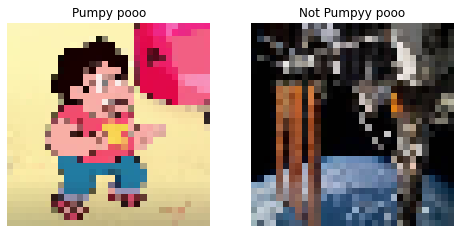

In [81]:
# FULL DATASET

full_ISS_dir = "/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/MKC"  # 602
full_Steven_dir = "/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена"  # 520

directory = [full_ISS_dir, full_Steven_dir]

classes = ['Not Pumpyy pooo', 'Pumpy pooo']

full_img_list = []
full_base = []

img_size = 32

train_base = []
test_base = []
temp_arr = []

only_img_list_tr = []
only_img_list_tt = []

for d_set_path in directory:
    print(d_set_path)  # debag
    os.chdir(d_set_path)
    current_class = 0 if '/MKC' in d_set_path else 1
    full_img_list.extend(download_set(os.getcwd(), current_class))
    temp_arr = download_set(os.getcwd(), current_class)
    print(len(temp_arr), current_class)  # debag
    full_base.extend([[i, current_class] for i in temp_arr])

magick(full_base[800], full_base[4])

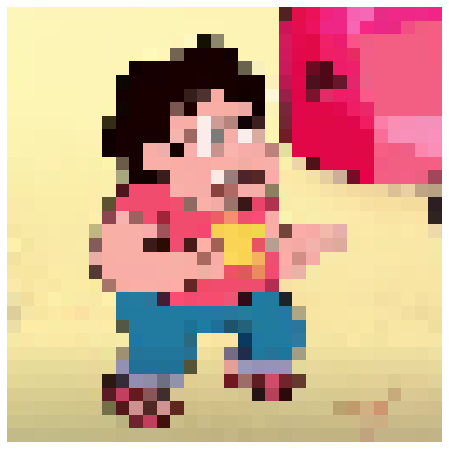

In [ ]:
magick(full_base[800])
# plt.savefig("/content/drive/MyDrive/CoolSteven.png")

In [82]:
# BUILDING A RIGHT ARRAY MODE

random.shuffle(full_base)

x_full = []
y_full = []

x_train = []
y_train = []

x_test = []
y_test = []

for img, cls in full_base:
    x_full.append(img)
    y_full.append(cls)

x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, img_size, img_size, 3)
x_train = x_train/255

x_test = x_test.reshape(-1, img_size, img_size, 3)
x_test = x_test/255

print(f'x_train shape is : {x_train.shape}')  # debag
print(f'x_test shape is : {x_test.shape}')  # debag

y_train = to_categorical(y_train, num_classes=2)
print(f'y_train shape is : {y_train.shape}')  # debag

y_test = to_categorical(y_test, num_classes = 2)

x_train shape is : (717, 32, 32, 3)
x_test shape is : (225, 32, 32, 3)
y_train shape is : (717, 2)


In [83]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [84]:
print(f'x_train is : {len(x_train)}')  # debag
print(f'x_val is : {len(x_val)}')  # debag
print(f'y_train is : {len(y_train)}')  # debag
print(f'y_val is : {len(y_val)}')  # debag

x_train is : 573
x_val is : 144
y_train is : 573
y_val is : 144


In [85]:
x_train1 = deepcopy(x_train)
x_val1 = deepcopy(x_val)
y_train1 = deepcopy(y_train)
y_val1 = deepcopy(y_val)

In [86]:
x_train2 = deepcopy(x_train)
x_val2 = deepcopy(x_val)
y_train2 = deepcopy(y_train)
y_val2 = deepcopy(y_val)

# **Модель 1**

In [87]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size)

Epoch 1/10
17/17 [==============================] - 1s 44ms/step - loss: 0.6031 - accuracy: 0.6950
Epoch 2/10
17/17 [==============================] - 1s 44ms/step - loss: 0.3032 - accuracy: 0.8965
Epoch 3/10
17/17 [==============================] - 1s 43ms/step - loss: 0.1575 - accuracy: 0.9538
Epoch 4/10
17/17 [==============================] - 1s 43ms/step - loss: 0.1174 - accuracy: 0.9612
Epoch 5/10
17/17 [==============================] - 1s 44ms/step - loss: 0.1215 - accuracy: 0.9612
Epoch 6/10
17/17 [==============================] - 1s 42ms/step - loss: 0.0791 - accuracy: 0.9778
Epoch 7/10
17/17 [==============================] - 1s 44ms/step - loss: 0.0711 - accuracy: 0.9723
Epoch 8/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0335 - accuracy: 0.9926
Epoch 9/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0428 - accuracy: 0.9871
Epoch 10/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0342 - accuracy: 0.9945


In [88]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               524416    
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 525,890
Trainable params: 525,890
Non-trainable params: 0
________________________________________________

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9487 |   0.9867 |     0.9673 |   75.0000 |
| Pumpy pooo      |      0.9848 |   0.9420 |     0.9630 |   69.0000 |
| avg / total     |      0.9660 |   0.9653 |     0.9652 |  144.0000 |


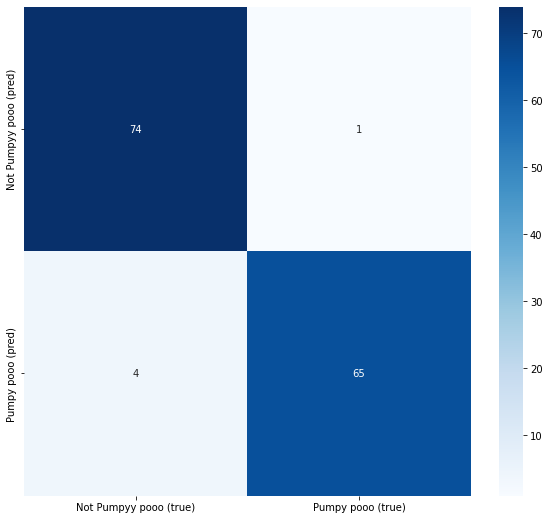

In [89]:
# CONTROL VALIDATION: MODEL

from google.colab import data_table

y_pred = model.predict(x_val)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_cls)
data_table.enable_dataframe_formatter()
print(classification_report(y_true, y_pred_cls))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9752 |   1.0000 |     0.9874 |  118.0000 |
| Pumpy pooo      |      1.0000 |   0.9720 |     0.9858 |  107.0000 |
| avg / total     |      0.9870 |   0.9867 |     0.9867 |  225.0000 |


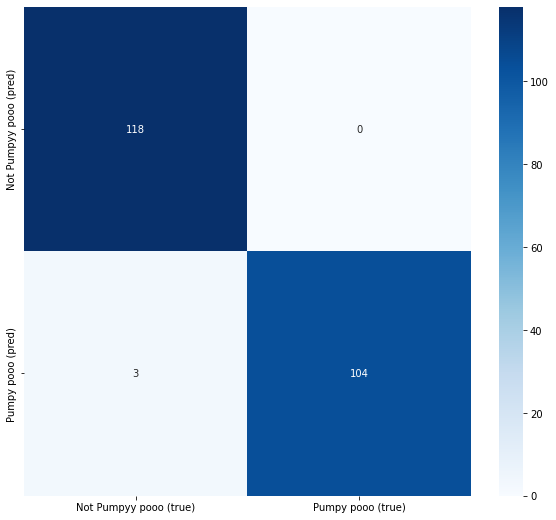

In [92]:
# TEST: MODEL

y_predt = model.predict(x_test)
y_pred_clst = np.argmax(y_predt, axis=1)
y_truet = np.argmax(y_test, axis=1)
conf_matt = confusion_matrix(y_truet, y_pred_clst)
print(classification_report(y_truet, y_pred_clst))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Blues')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

# **Модель 2**

In [93]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train1)
history = model1.fit(datagen.flow(x_train1, y_train1, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train1.shape[0]//batch_size)

Epoch 1/10
17/17 [==============================] - 1s 34ms/step - loss: 0.6622 - accuracy: 0.5915
Epoch 2/10
17/17 [==============================] - 1s 36ms/step - loss: 0.3307 - accuracy: 0.9039
Epoch 3/10
17/17 [==============================] - 1s 33ms/step - loss: 0.1622 - accuracy: 0.9501
Epoch 4/10
17/17 [==============================] - 1s 37ms/step - loss: 0.0914 - accuracy: 0.9723
Epoch 5/10
17/17 [==============================] - 1s 34ms/step - loss: 0.0700 - accuracy: 0.9852
Epoch 6/10
17/17 [==============================] - 1s 34ms/step - loss: 0.0480 - accuracy: 0.9852
Epoch 7/10
17/17 [==============================] - 1s 52ms/step - loss: 0.0542 - accuracy: 0.9871
Epoch 8/10
17/17 [==============================] - 1s 35ms/step - loss: 0.0465 - accuracy: 0.9908
Epoch 9/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0364 - accuracy: 0.9908
Epoch 10/10
17/17 [==============================] - 1s 52ms/step - loss: 0.0232 - accuracy: 0.9982


In [94]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 4096)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               524416    
                                                                 
 dense_17 (Dense)            (None, 2)                 258       
                                                                 
Total params: 525,122
Trainable params: 525,122
Non-trainable params: 0
________________________________________________

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      1.0000 |   0.9600 |     0.9796 |   75.0000 |
| Pumpy pooo      |      0.9583 |   1.0000 |     0.9787 |   69.0000 |
| avg / total     |      0.9800 |   0.9792 |     0.9792 |  144.0000 |


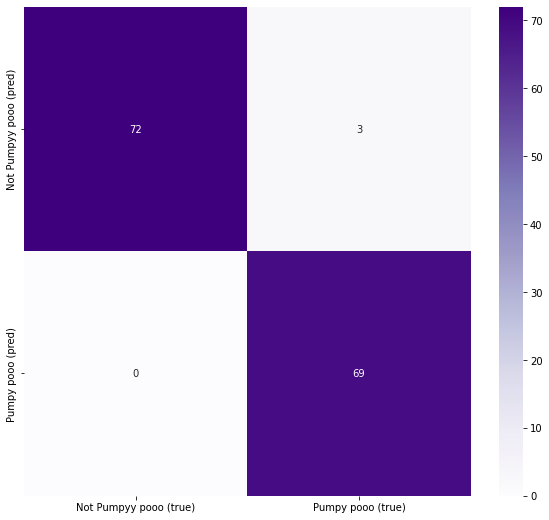

In [95]:
# CONTROL VALIDATION: MODEL1

from google.colab import data_table

y_pred = model1.predict(x_val1)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val1, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_cls)
data_table.enable_dataframe_formatter()
print(classification_report(y_true, y_pred_cls))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Purples')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      1.0000 |   0.9915 |     0.9957 |  118.0000 |
| Pumpy pooo      |      0.9907 |   1.0000 |     0.9953 |  107.0000 |
| avg / total     |      0.9956 |   0.9956 |     0.9956 |  225.0000 |


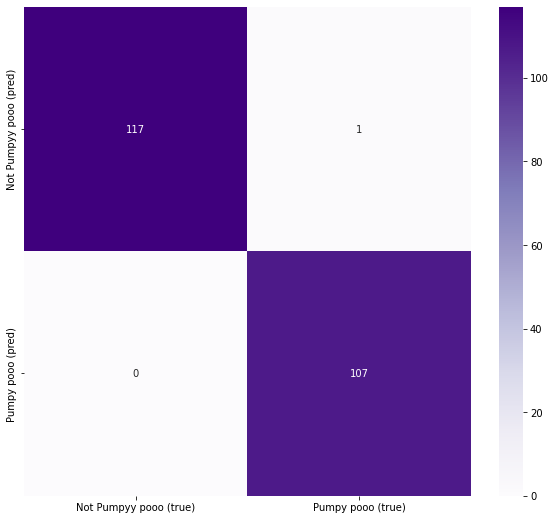

In [96]:
# TEST: MODEL1

y_predt = model1.predict(x_test)
y_pred_clst = np.argmax(y_predt, axis=1)
y_truet = np.argmax(y_test, axis=1)
conf_matt = confusion_matrix(y_truet, y_pred_clst)
print(classification_report(y_truet, y_pred_clst))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Purples')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

# **Модель 3**

In [97]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16))
model2.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train2)
history = model2.fit(datagen.flow(x_train2, y_train2, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train2.shape[0]//batch_size)

Epoch 1/10
17/17 [==============================] - 1s 32ms/step - loss: 0.7181 - accuracy: 0.6359
Epoch 2/10
17/17 [==============================] - 1s 32ms/step - loss: 0.2870 - accuracy: 0.9118
Epoch 3/10
17/17 [==============================] - 1s 34ms/step - loss: 0.1616 - accuracy: 0.9519
Epoch 4/10
17/17 [==============================] - 1s 32ms/step - loss: 0.1115 - accuracy: 0.9686
Epoch 5/10
17/17 [==============================] - 1s 34ms/step - loss: 0.0800 - accuracy: 0.9704
Epoch 6/10
17/17 [==============================] - 1s 32ms/step - loss: 0.0720 - accuracy: 0.9815
Epoch 7/10
17/17 [==============================] - 1s 33ms/step - loss: 0.0553 - accuracy: 0.9778
Epoch 8/10
17/17 [==============================] - 1s 32ms/step - loss: 0.0487 - accuracy: 0.9815
Epoch 9/10
17/17 [==============================] - 1s 32ms/step - loss: 0.0425 - accuracy: 0.9890
Epoch 10/10
17/17 [==============================] - 1s 31ms/step - loss: 0.0270 - accuracy: 0.9926


In [98]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 32)                131104    
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 2)                 34        
                                                      

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      1.0000 |   0.9600 |     0.9796 |   75.0000 |
| Pumpy pooo      |      0.9583 |   1.0000 |     0.9787 |   69.0000 |
| avg / total     |      0.9800 |   0.9792 |     0.9792 |  144.0000 |


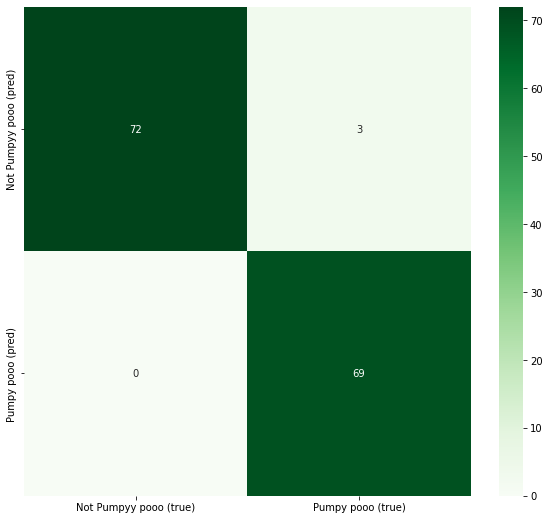

In [99]:
# CONTROL VALIDATION: MODEL2

from google.colab import data_table

y_pred2 = model2.predict(x_val2)
y_pred_cls2 = np.argmax(y_pred, axis=1)
y_true2 = np.argmax(y_val2, axis=1)
conf_mat2 = confusion_matrix(y_true2, y_pred_cls2)
data_table.enable_dataframe_formatter()
print(classification_report(y_true2, y_pred_cls2))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat2, annot=True, fmt='.0f', cmap='Greens')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9916 |   1.0000 |     0.9958 |  118.0000 |
| Pumpy pooo      |      1.0000 |   0.9907 |     0.9953 |  107.0000 |
| avg / total     |      0.9956 |   0.9956 |     0.9956 |  225.0000 |


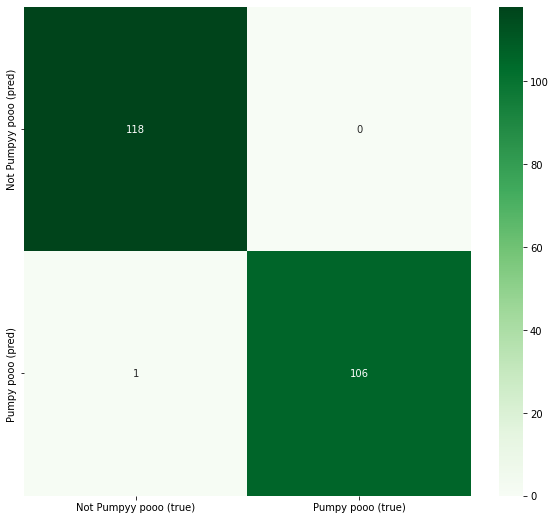

In [100]:
# TEST: MODEL2

y_predt = model2.predict(x_test)
y_pred_clst = np.argmax(y_predt, axis=1)
y_truet = np.argmax(y_test, axis=1)
conf_matt = confusion_matrix(y_truet, y_pred_clst)
print(classification_report(y_truet, y_pred_clst))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Greens')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

In [ ]:
# os.remove('/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена/Screenshot_520.png')

# **Единичное предсказание по ссылке**

*   Было упомянуто, что если что-то будет не так, то будете выборочную фотку по ссылке загружать в predict. Не знаем требовалось ли это делать, но теперь можно вставить через get_check ссылку на картинку. Примеры на которых работало в комментариях. Не работало только с картинками, которые по видимому были заблокированы для такой операции (по нашему мнению, может ошибаемся).
*   Убрали отчёт, потому что слишком круто для одной картинки. 

In [103]:
def get_check(link, class_name):
    global img_size
    global true
    
    true = class_name
    fd = urlopen(link)

    image_file = io.BytesIO(fd.read())
    img = Image.open(image_file)
    img_arr = np.array(img)
    img_arr[20,30]
    plt.axis('off')


    img_arr = cv2.resize(img_arr, dsize=(img_size, img_size))

    plt.imshow(img_arr)  # debag
    
    # plt.savefig("/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена/Screenshot_520.png")


    img_arr = img_arr.reshape(-1, img_size, img_size, 3)
    img_arr = img_arr/255

    return img_arr

**Пояснение к использованию:**


---

Вставлять ссылку вместо уже вставленной как пример ссылки. 

Вторым параметром служит класс изображения на данной картинке. Он будет использоваться как верное значение, с которым будет сравниваться наше предсказание. Названия класса примлемы только в виде 'Steven' и 'ISS'. 


Predict: its Pumpy pooo
Probability is: 99.96700286865234%


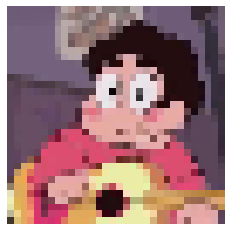

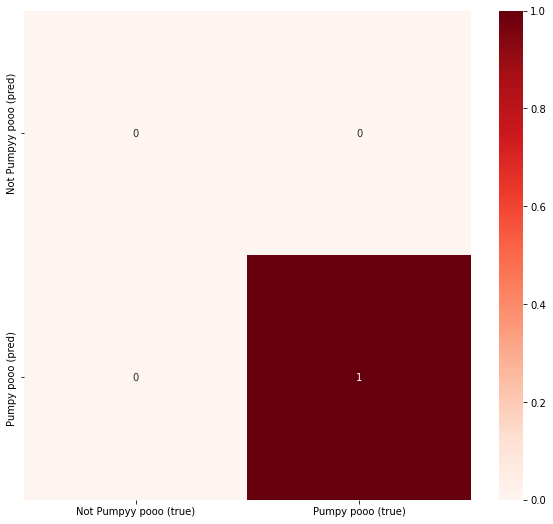

In [105]:
# URL IMAGE WORK ON MODEL

# Pumpy pooo
# https://c-cl.cdn.smule.com/rs-s87/arr/f8/65/e4b2a575-fbf4-4611-8f10-643c4b94bac6.jpg
# https://media.myshows.me/shows/1920/c/19/c19d86c712121a60f9ad75979d5860f7.jpg
# https://slovnet.ru/wp-content/uploads/2018/08/1-29.jpg  # dark bg

# Not Pumpyy pooo
# https://cdni.russiatoday.com/rbthmedia/images/2020.12/article/5feb853a85600a4a470fb151.jpg 

true = str

y_pred = model.predict(get_check("https://c-cl.cdn.smule.com/rs-s87/arr/f8/65/e4b2a575-fbf4-4611-8f10-643c4b94bac6.jpg ", 'Steven'))
y_pred_cls = np.argmax(y_pred, axis=1)

if true == 'Steven':
    y_true = [1] 
elif true == 'ISS':
    y_true = [0]
if y_true == y_pred_cls:
    print(f'Predict: its {classes[y_pred_cls[0]]}')
    print(f'Probability is: {round(np.amax([item * 100 for item in y_pred]), 3)}%')
else:
    print(f'Error. Its not {true}')
    print("y_pred = ", y_pred * 100)

conf_mat = confusion_matrix(y_true, y_pred_cls, labels=[0, 1])
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Reds')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()